In [1]:
# Projekt: Schlaganfall-Risiko – Modellierung & Algorithmen
# ---------------------------------------------------------
# Dieses Notebook enthält die Anwendung und den Vergleich 
# verschiedener Machine-Learning-Algorithmen zur Vorhersage 
# des Schlaganfall-Risikos.
#
# Ziel: Ein Modell entwickeln, das Schlaganfälle möglichst
# zuverlässig erkennt. Dabei steht ein hoher Recall (möglichst
# wenige übersehene Schlaganfälle) im Vordergrund, auch wenn
# dies zu mehr False Positives führt.
#
# Schritte:
# 1. Train-Test-Split
# 2. Umgang mit Klassenungleichgewicht (Balancing)
# 3. Training mehrerer Klassifikationsmodelle 
# 4. Vergleich der Modelle anhand von Recall, Precision,
#    F1-Score und ROC-AUC
# 5. Auswahl des am besten geeigneten Modells

In [3]:
# Bibliotheken laden
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocessing & Modellaufbau
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Scikit-learn: Modelle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Scikit-learn: Metriken & Visualisierung
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, PrecisionRecallDisplay, average_precision_score,
    RocCurveDisplay
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Statsmodels
import statsmodels.formula.api as smf

In [4]:
# Daten einlesen
df_kopie = pd.read_csv('df_aufbereitet.csv')

In [5]:
# Struktur der Daten
# Der Datensatz umfasst 5110 Zeilen und 11 Spalten.
print(df_kopie.shape)

(5109, 11)


In [6]:
# Train-Test-Split
X = df_kopie.drop('stroke', axis=1)
y = df_kopie['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape
X_test.shape

(1022, 10)

In [7]:
print("Train (prozentual):")
print(y_train.value_counts(normalize=True))

print("\nTest (prozentual):")
print(y_test.value_counts(normalize=True))

Train (prozentual):
stroke
0    0.951309
1    0.048691
Name: proportion, dtype: float64

Test (prozentual):
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64


In [8]:
# Imputationen

In [9]:
# BMI: Fehlende Werte durch Median ersetzen
num_imputer = SimpleImputer(strategy='median')
X_train['bmi'] = num_imputer.fit_transform(X_train[['bmi']]).ravel()

In [10]:
# Simple Imputer für BMI auf Testdaten
X_test['bmi'] = num_imputer.transform(X_test[['bmi']]).ravel()

In [11]:
# Smoking Unknown durch Modus
cat_imputer = SimpleImputer(strategy='most_frequent', missing_values='Unknown')
X_train['smoking_status'] = cat_imputer.fit_transform(X_train[['smoking_status']]).ravel()

In [12]:
# Smoking Unknown durch Modus, bei Testdaten
X_test['smoking_status'] = cat_imputer.transform(X_test[['smoking_status']]).ravel()

In [13]:
# Überprüfung, ob Imputation erfolgreich war
print(X_train.head())

      gender   age  hypertension  heart_disease ever_married work_type  \
845   Female  48.0             0              0          Yes   Private   
3744  Female  29.0             0              0           No   Private   
4183  Female  35.0             0              0          Yes   Private   
3409    Male  38.0             0              0          Yes   Private   
284     Male  14.0             0              0           No  Govt_job   

     Residence_type  avg_glucose_level   bmi smoking_status  
845           Urban              69.21  33.1   never smoked  
3744          Urban              84.19  21.2   never smoked  
4183          Rural             119.40  22.9   never smoked  
3409          Rural             108.68  32.7   never smoked  
284           Urban              82.34  31.6   never smoked  


In [14]:
print(X_test.head())

      gender   age  hypertension  heart_disease ever_married work_type  \
3666  Female  28.0             1              0          Yes  Govt_job   
2217  Female   3.0             0              0           No  children   
374   Female  53.0             0              0          Yes  Govt_job   
2392    Male  35.0             0              0          Yes   Private   
299   Female  58.0             0              0          Yes   Private   

     Residence_type  avg_glucose_level   bmi smoking_status  
3666          Rural              83.66  36.4   never smoked  
2217          Urban              93.30  19.5   never smoked  
374           Rural              64.40  31.0         smokes  
2392          Rural              69.22  42.8   never smoked  
299           Rural              94.30  29.1   never smoked  


In [15]:
# Encoding

# Liste der zu codierenden Spalten
ordinal_cols = ['gender', 'ever_married', 'Residence_type']

# OrdinalEncoder initialisieren
# Zuordnung festlegen: 0: Male; No; Urban, 1: Female; Yes; Rural
encoder = OrdinalEncoder(dtype=int, categories=[['Male', 'Female'],
                                     ['No', 'Yes'],
                                     ['Urban', 'Rural']])

# Nur die entsprechenden Spalten encodieren
X_train[ordinal_cols] = encoder.fit_transform(X_train[ordinal_cols])

In [16]:
print(X_train.head())

      gender   age  hypertension  heart_disease  ever_married work_type  \
845        1  48.0             0              0             1   Private   
3744       1  29.0             0              0             0   Private   
4183       1  35.0             0              0             1   Private   
3409       0  38.0             0              0             1   Private   
284        0  14.0             0              0             0  Govt_job   

      Residence_type  avg_glucose_level   bmi smoking_status  
845                0              69.21  33.1   never smoked  
3744               0              84.19  21.2   never smoked  
4183               1             119.40  22.9   never smoked  
3409               1             108.68  32.7   never smoked  
284                0              82.34  31.6   never smoked  


In [17]:
# Encoding auf Testdaten
X_test[ordinal_cols] = encoder.transform(X_test[ordinal_cols])

In [18]:
categorical_cols = ['work_type', 'smoking_status']

ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first'), categorical_cols)],
    remainder='passthrough'  # numerische Spalten unverändert lassen
)

X_train = ct.fit_transform(X_train)

In [19]:
feature_names = ct.get_feature_names_out()
X_train_encoded = pd.DataFrame(X_train, columns=feature_names)
X_train_encoded.head()

,encoder__work_type_Never_worked,encoder__work_type_Private,encoder__work_type_Self-employed,encoder__work_type_children,encoder__smoking_status_never smoked,encoder__smoking_status_smokes,remainder__gender,remainder__age,remainder__hypertension,remainder__heart_disease,remainder__ever_married,remainder__Residence_type,remainder__avg_glucose_level,remainder__bmi
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,48.0,0.0,0.0,1.0,0.0,69.21,33.1
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,29.0,0.0,0.0,0.0,0.0,84.19,21.2
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,35.0,0.0,0.0,1.0,1.0,119.40,22.9
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,38.0,0.0,0.0,1.0,1.0,108.68,32.7
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,82.34,31.6


In [20]:
X_test = ct.transform(X_test)

In [21]:
feature_names = ct.get_feature_names_out()
X_test_encoded = pd.DataFrame(X_test, columns=feature_names)
X_test_encoded.head()

,encoder__work_type_Never_worked,encoder__work_type_Private,encoder__work_type_Self-employed,encoder__work_type_children,encoder__smoking_status_never smoked,encoder__smoking_status_smokes,remainder__gender,remainder__age,remainder__hypertension,remainder__heart_disease,remainder__ever_married,remainder__Residence_type,remainder__avg_glucose_level,remainder__bmi
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,28.0,1.0,0.0,1.0,1.0,83.66,36.4
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,93.30,19.5
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,53.0,0.0,0.0,1.0,1.0,64.40,31.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,35.0,0.0,0.0,1.0,1.0,69.22,42.8
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,58.0,0.0,0.0,1.0,1.0,94.30,29.1


In [22]:
X_train_encoded.to_csv('X_train_imputiert_encoded.csv', index=False)
X_test_encoded.to_csv('X_test_imputiert_encoded.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [23]:
# Evaluierungsfunktion
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Modell'):
    """
    Evaluiert ein Modell mit Trainings- und Testdaten.
    Gibt Accuracy, Precision, Recall, F1, ROC-AUC für beide Datensätze aus.
    Zeigt Confusion Matrix und ROC-Kurve für Testdaten.
    """
    # Vorhersagen
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Trainingsmetriken
    acc_train = accuracy_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train, zero_division=0)
    rec_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    roc_auc_train = roc_auc_score(y_train, y_proba_train) if y_proba_train is not None else None

    # Testmetriken
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test, zero_division=0)
    rec_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None


    # Ausgabe
    print(f"\n**Bewertung für Modell: {model_name}**\n")
    print("Trainingsdaten:")
    print(f"  Accuracy     : {acc_train:.4f}")
    print(f"  Precision    : {prec_train:.4f}")
    print(f"  Recall       : {rec_train:.4f}")
    print(f"  F1-Score     : {f1_train:.4f}")
    print(f"  ROC-AUC      : {roc_auc_train:.4f}" if roc_auc_train is not None else "  ROC-AUC      : nicht verfügbar")

    print("\nTestdaten:")
    print(f"  Accuracy     : {acc_test:.4f}")
    print(f"  Precision    : {prec_test:.4f}")
    print(f"  Recall       : {rec_test:.4f}")
    print(f"  F1-Score     : {f1_test:.4f}")
    print(f"  ROC-AUC      : {roc_auc_test:.4f}" if roc_auc_test is not None else "  ROC-AUC      : nicht verfügbar")
    

    # Confusion Matrix (Test)
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel("Predicted") 
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC-Kurve (Test)
    if y_proba_test is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba_test, name=model_name)
        plt.title(f'ROC-Kurve: {model_name}')
        plt.grid(True)
        plt.show()

    # Precision- Recall Curve (Test
    # Precision-Recall-Werte und Average Precision Score berechnen

    if y_proba_test is not None:
        # Berechnung der Precision- Recall ndArray - Paare
        precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test) # prec and rec von score Funktionen oben geben jeweils nur einen einzelnen Wert zurück für default threshold 0.5
        average_precision = average_precision_score(y_test, y_proba_test)
        plt.plot(recall, precision, label=f'PR Kurve (Average precision = {average_precision:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Kurve {model_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Rückgabe als Dictionary (für spätere Sammlung)
    return {
        'Model': model_name,
        'Train Accuracy': acc_train,
        'Train Precision': prec_train,
        'Train Recall': rec_train,
        'Train F1': f1_train,
        'Train ROC-AUC': roc_auc_train,
        'Test Accuracy': acc_test,
        'Test Precision': prec_test,
        'Test Recall': rec_test,
        'Test F1': f1_test,
        'Test ROC-AUC': roc_auc_test,
    }

In [24]:
# Modellvergleich mit SMOTE

# Alle Modelle verwenden hier SMOTE und KEIN class_weight
# Modellliste: (Name, Modell, Skalierung erforderlich)
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42), True),
    ('Naive Bayes', GaussianNB(), False),
    ('KNN', KNeighborsClassifier(n_neighbors=5), True),
    ('Decision Tree', DecisionTreeClassifier(random_state=42), False),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42), False),
    ('SVM', SVC(probability=True, random_state=42), True),
    ('Neural Net', MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42), True)
]

results = []

for name, model, needs_scaling in models:
    steps = []

    # Optional: Skalierung
    if needs_scaling:
        steps.append(('scaler', StandardScaler()))
    
    # Immer SMOTE
    steps.append(('smote', SMOTE(random_state=42)))

    steps.append(('clf', model))

    pipe = ImbPipeline(steps)

    # Fit & Predict
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
   
    
    results.append({
        'Modell': name,
        'Train Accuracy': pipe.score(X_train, y_train),
        'Test Accuracy': pipe.score(X_test, y_test),
        'Recall (1)': report['1']['recall'],
        'Precision (1)': report['1']['precision'],
        'F1-Score (1)': report['1']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
    })

# Ergebnisse als DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='F1-Score (1)', ascending=False)
print(df_results)


                Modell  Train Accuracy  Test Accuracy  Recall (1)  \
0  Logistic Regression        0.748960       0.740705        0.80   
5                  SVM        0.817959       0.789628        0.54   
6           Neural Net        0.915831       0.838552        0.34   
2                  KNN        0.885001       0.805284        0.36   
1          Naive Bayes        0.412528       0.419765        0.98   
3        Decision Tree        1.000000       0.891389        0.18   
4        Random Forest        1.000000       0.946184        0.04   

   Precision (1)  F1-Score (1)   ROC-AUC  
0       0.135593      0.231884  0.839959  
5       0.123288      0.200743  0.766975  
6       0.114094      0.170854  0.734444  
2       0.097297      0.153191  0.656317  
1       0.076443      0.141823  0.792160  
3       0.113924      0.139535  0.553992  
4       0.222222      0.067797  0.751101  


In [25]:
# Modelloptimierung
# 1. Naive Bayes
# 2. Logistic Regression
# 3. K-nearest-Neighbor
# 4. Decision Tree
# 5. Random Forest
# 6. Neuronale Netze
# 7. Support Vector Machine

In [26]:
# 1. Naive Bayes
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()


**Bewertung für Modell: Beste NaiveBayes**

Trainingsdaten:
  Accuracy     : 0.7805
  Precision    : 0.7148
  Recall       : 0.9334
  F1-Score     : 0.8096
  ROC-AUC      : 0.8434

Testdaten:
  Accuracy     : 0.6321
  Precision    : 0.0925
  Recall       : 0.7400
  F1-Score     : 0.1644
  ROC-AUC      : 0.7991


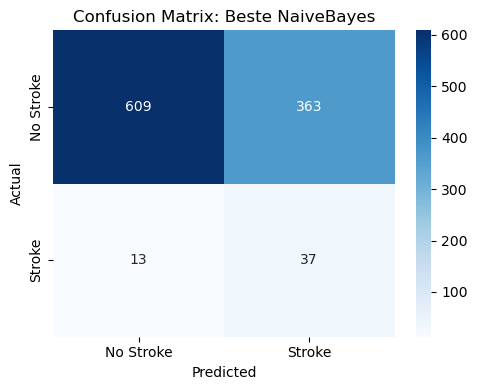

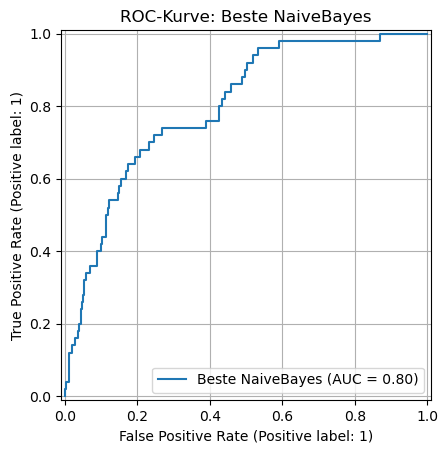

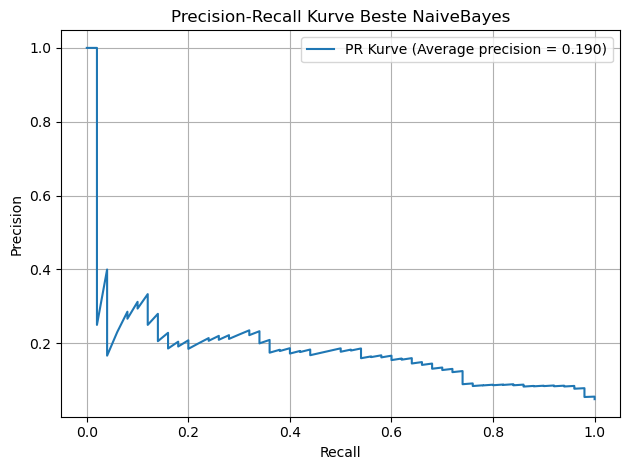

{'Model': 'Beste NaiveBayes',
 'Train Accuracy': 0.7804783950617284,
 'Train Precision': 0.71479220011818,
 'Train Recall': 0.9333847736625515,
 'Train F1': 0.8095928611266034,
 'Train ROC-AUC': 0.8434466899312435,
 'Test Accuracy': 0.6320939334637965,
 'Test Precision': 0.0925,
 'Test Recall': 0.74,
 'Test F1': 0.16444444444444445,
 'Test ROC-AUC': 0.799074074074074}

In [27]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
GaussianNBbest_model = GaussianNB(priors = None, var_smoothing = 1e-05)
GaussianNBbest_model.fit(X_train_res, y_train_res)

# Verwendung der Evaluierungsfunktion
evaluate_model(GaussianNBbest_model, X_train_res, y_train_res, X_test, y_test, model_name='Beste NaiveBayes')

In [28]:
# 2. Logistic Regression
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()


**Bewertung für Modell: Beste Logistische Regression**

Trainingsdaten:
  Accuracy     : 0.6396
  Precision    : 0.1111
  Recall       : 0.9146
  F1-Score     : 0.1981
  ROC-AUC      : 0.8367

Testdaten:
  Accuracy     : 0.6409
  Precision    : 0.1067
  Recall       : 0.8600
  F1-Score     : 0.1898
  ROC-AUC      : 0.8321


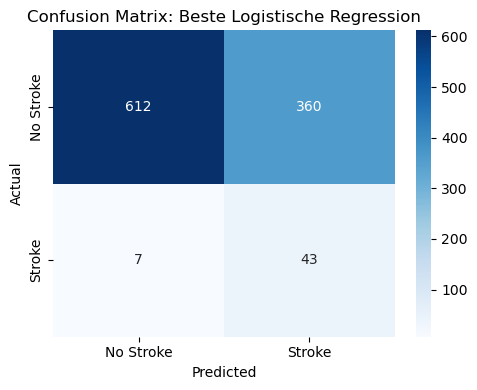

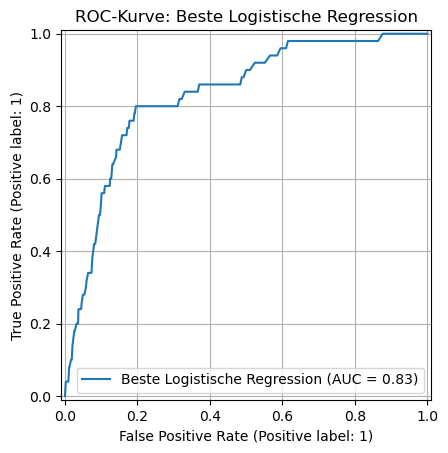

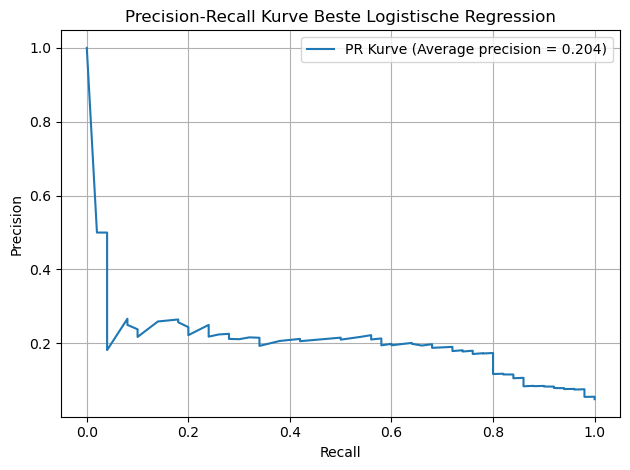

{'Model': 'Beste Logistische Regression',
 'Train Accuracy': 0.6395889405431857,
 'Train Precision': 0.1111111111111111,
 'Train Recall': 0.914572864321608,
 'Train F1': 0.19814915623298857,
 'Train ROC-AUC': 0.8366853557913022,
 'Test Accuracy': 0.6409001956947162,
 'Test Precision': 0.10669975186104218,
 'Test Recall': 0.86,
 'Test F1': 0.18984547461368653,
 'Test ROC-AUC': 0.832067901234568}

In [29]:
# Beste Konfiguration laut Optimierung
best_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        C=0.01,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000
    ))
])
# bestes Modell trainieren
best_model.fit(X_train, y_train)
# Verwendung der Evaluierungsfunktion
evaluate_model(best_model, X_train, y_train, X_test, y_test, model_name='Beste Logistische Regression')

In [30]:
# Analyse False-Positives: Wer sind die False-Positives?
# Indexe für FP und TN
fp_mask = (y_test == 0) & (y_pred == 1)  # falsch-positiv
tn_mask = (y_test == 0) & (y_pred == 0)  # korrekt negativ

# Extrahiere Datenpunkte
fp_cases = X_test[fp_mask]
tn_cases = X_test[tn_mask]
# Vergleich der Mittelwerte
mean_fp = fp_cases.mean()
mean_tn = tn_cases.mean()

# In DataFrame zusammenfassen
comparison = pd.DataFrame({
    'False Positives (Ø)': mean_fp,
    'True Negatives (Ø)': mean_tn,
    'Differenz': mean_fp - mean_tn
})

# Sortieren nach Differenz
comparison_sorted = comparison.sort_values(by='Differenz', ascending=False)
print(comparison_sorted)

                                      False Positives (Ø)  True Negatives (Ø)  \
remainder__age                                  66.265152           37.994000   
remainder__avg_glucose_level                   128.678864          101.946905   
remainder__bmi                                  29.960606           28.688333   
remainder__ever_married                          0.939394            0.580952   
remainder__hypertension                          0.257576            0.077381   
encoder__work_type_Self-employed                 0.250000            0.133333   
remainder__gender                                0.636364            0.576190   
encoder__work_type_Private                       0.621212            0.576190   
remainder__heart_disease                         0.068182            0.028571   
remainder__Residence_type                        0.484848            0.467857   
encoder__work_type_Never_worked                  0.000000            0.007143   
encoder__smoking_status_smok

In [31]:
# 3. K-Nearest-Neigbor
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()

Cross Validation Score:	0.9879


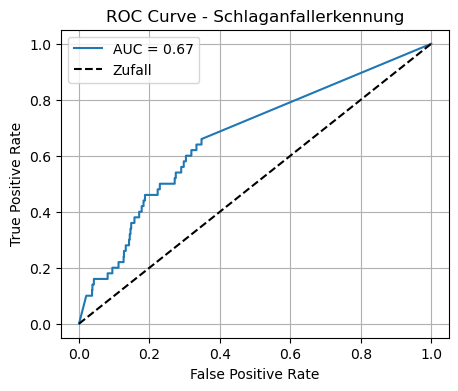

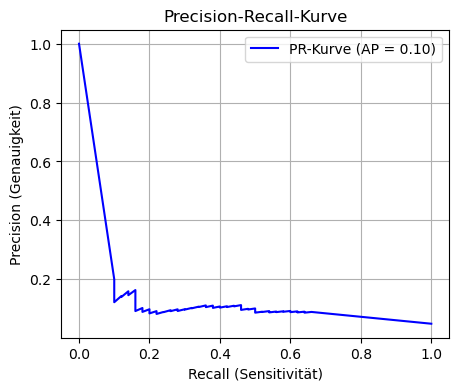

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81       972
           1       0.09      0.60      0.16        50

    accuracy                           0.69      1022
   macro avg       0.53      0.65      0.48      1022
weighted avg       0.93      0.69      0.78      1022



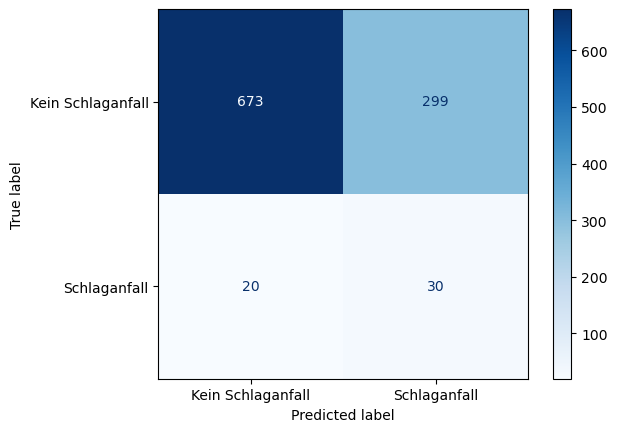

In [32]:
scr = "recall" # Scoring-Methoden: recall, f1

mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_test = mm_scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(X_train, y_train)

knn = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=10, p=2, weights='distance')
knn.fit(X_train, Y_train)
print(f"Cross Validation Score:\t{(cross_val_score(knn, X_train, Y_train, cv=10, scoring=scr)).mean():.4f}")

y_proba = knn.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Zufall")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Schlaganfallerkennung")
plt.legend()
plt.grid(True)
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color="blue", label=f"PR-Kurve (AP = {avg_precision:.2f})")
plt.xlabel("Recall (Sensitivität)")
plt.ylabel("Precision (Genauigkeit)")
plt.title("Precision-Recall-Kurve")
plt.legend()
plt.grid(True)
plt.show()

threshold = 0.1
y_pred_proba = (y_proba >= threshold).astype(int)
print(f"Classification Report:\n{classification_report(y_test, y_pred_proba)}")
cm = confusion_matrix(y_test, y_pred_proba)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kein Schlaganfall", "Schlaganfall"])
disp.plot(cmap="Blues", colorbar=True)

In [33]:
# 4. Decision Tree
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()


**Bewertung für Modell: Beste DecisionTree**

Trainingsdaten:
  Accuracy     : 0.7857
  Precision    : 0.1736
  Recall       : 0.9045
  F1-Score     : 0.2913
  ROC-AUC      : 0.8846

Testdaten:
  Accuracy     : 0.7730
  Precision    : 0.1527
  Recall       : 0.8000
  F1-Score     : 0.2564
  ROC-AUC      : 0.8232


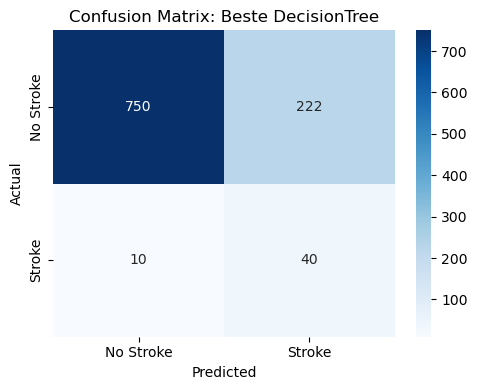

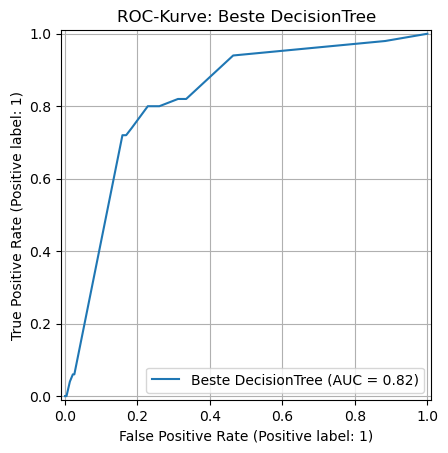

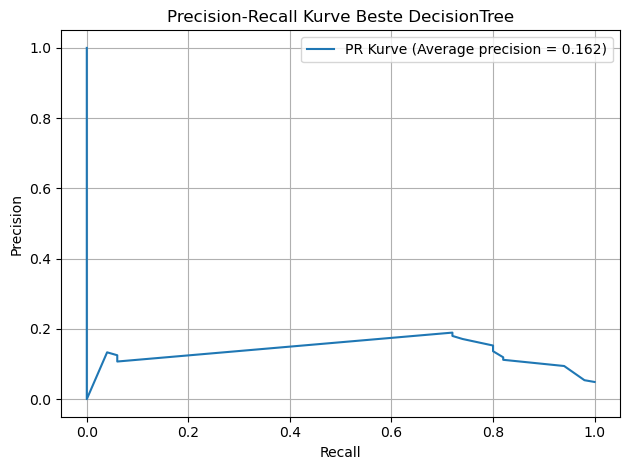

{'Model': 'Beste DecisionTree',
 'Train Accuracy': 0.7856618546611206,
 'Train Precision': 0.17357762777242045,
 'Train Recall': 0.9045226130653267,
 'Train F1': 0.2912621359223301,
 'Train ROC-AUC': 0.8845629898463512,
 'Test Accuracy': 0.7729941291585127,
 'Test Precision': 0.15267175572519084,
 'Test Recall': 0.8,
 'Test F1': 0.2564102564102564,
 'Test ROC-AUC': 0.82320987654321}

In [34]:
# Erst außerhalb das Modell definieren
decisionTree = DecisionTreeClassifier(
    ccp_alpha=0.0,
    class_weight='balanced',
    criterion='gini',
    max_depth=8,
    max_leaf_nodes=30,
    splitter='best',
    random_state=42
)

# in die Pipeline einfügen
DecisionTree = Pipeline([
    ('clf', decisionTree)
])

# bestes Modell trainieren
DecisionTree.fit(X_train, y_train)
# Verwendung der Evaluierungsfunktion
evaluate_model(DecisionTree, X_train, y_train, X_test, y_test, model_name='Beste DecisionTree')


**Bewertung für Modell: Beste Random Forest**

Trainingsdaten:
  Accuracy     : 0.7945
  Precision    : 0.1817
  Recall       : 0.9196
  F1-Score     : 0.3035
  ROC-AUC      : 0.9386

Testdaten:
  Accuracy     : 0.7710
  Precision    : 0.1489
  Recall       : 0.7800
  F1-Score     : 0.2500
  ROC-AUC      : 0.8262


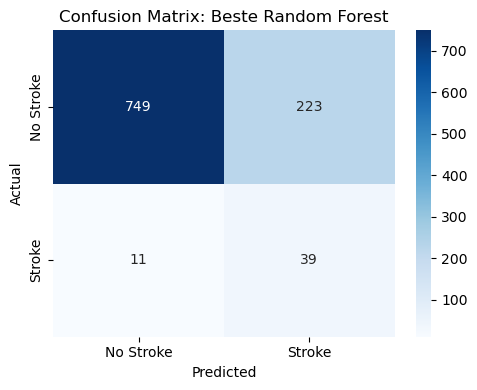

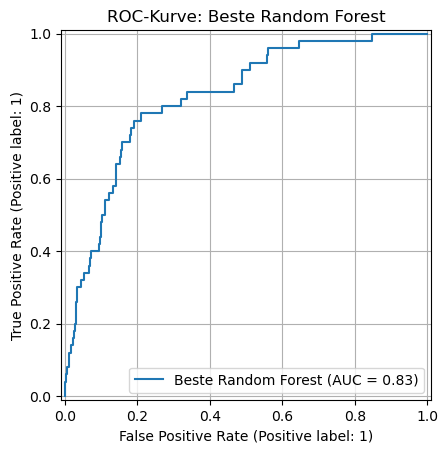

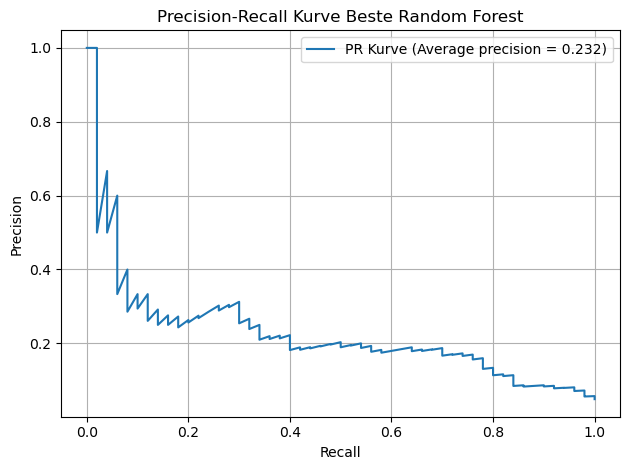

{'Model': 'Beste Random Forest',
 'Train Accuracy': 0.7944702715928554,
 'Train Precision': 0.1817279046673287,
 'Train Recall': 0.9195979899497487,
 'Train F1': 0.3034825870646766,
 'Train ROC-AUC': 0.9386166945840313,
 'Test Accuracy': 0.7710371819960861,
 'Test Precision': 0.14885496183206107,
 'Test Recall': 0.78,
 'Test F1': 0.25,
 'Test ROC-AUC': 0.8261728395061729}

In [35]:
# 5. Radom Forest
# Erst außerhalb das Modell definieren
# Random Forest Modell separat definieren
random_forest_model = RandomForestClassifier(
    ccp_alpha=0.0,
    class_weight='balanced',
    criterion='gini',
    max_depth=16,
    max_leaf_nodes=32,
    n_estimators=200,
    random_state=42
)

# Pipeline mit dem Modell
randomForest = Pipeline([
    ('clf', random_forest_model)
])

# bestes Modell trainieren
randomForest.fit(X_train, y_train)
# Verwendung der Evaluierungsfunktion
evaluate_model(randomForest, X_train, y_train, X_test, y_test, model_name='Beste Random Forest')

In [36]:
# 6. Neuronale Netze
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()


**Bewertung für Modell: Beste Neuronale Netze**

Trainingsdaten:
  Accuracy     : 0.7704
  Precision    : 0.7342
  Recall       : 0.8477
  F1-Score     : 0.7869
  ROC-AUC      : 0.8329

Testdaten:
  Accuracy     : 0.7055
  Precision    : 0.1185
  Recall       : 0.7800
  F1-Score     : 0.2058
  ROC-AUC      : 0.7980


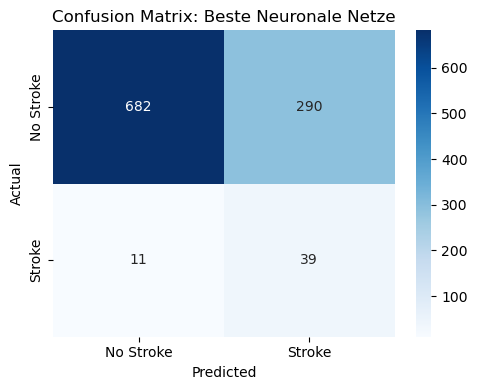

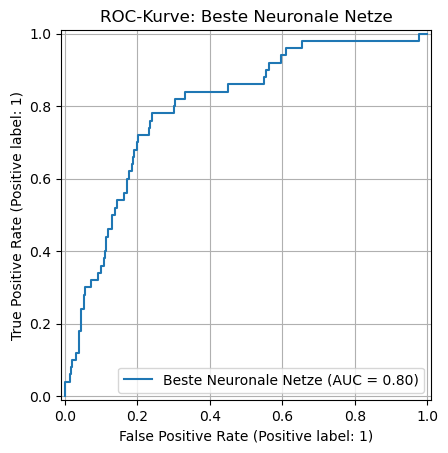

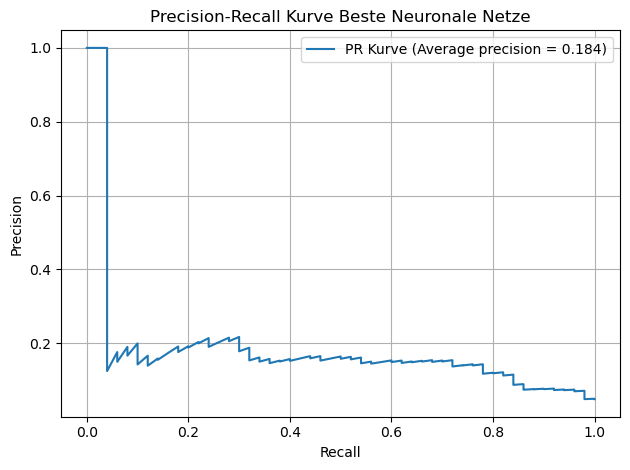

{'Model': 'Beste Neuronale Netze',
 'Train Accuracy': 0.7704475308641975,
 'Train Precision': 0.7342392515036756,
 'Train Recall': 0.8477366255144033,
 'Train F1': 0.786916557240062,
 'Train ROC-AUC': 0.8328972548222664,
 'Test Accuracy': 0.7054794520547946,
 'Test Precision': 0.11854103343465046,
 'Test Recall': 0.78,
 'Test F1': 0.20580474934036938,
 'Test ROC-AUC': 0.7980041152263375}

In [37]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

best_modelNN = Pipeline([
    ('scaler', MinMaxScaler()),
    ('mlp', MLPClassifier(
        random_state=42,
        hidden_layer_sizes=(16,),
        activation='tanh',
        solver='sgd',
        alpha=0.0001,
        max_iter=1000,
        learning_rate='constant',
        early_stopping=True
    ))
])


# bestes Modell trainieren
best_modelNN.fit(X_train_res, y_train_res)
# Verwendung der Evaluierungsfunktion
evaluate_model(best_modelNN, X_train_res, y_train_res, X_test, y_test, model_name='Beste Neuronale Netze')

In [38]:
# 7. Support Vector Machine
# Daten laden
X_train = pd.read_csv('X_train_imputiert_encoded.csv')
X_test = pd.read_csv('X_test_imputiert_encoded.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # .ravel(), falls y ein DataFrame mit 1 Spalte ist
y_test = pd.read_csv('y_test.csv').values.ravel()


**Bewertung für Modell: Beste Support Vector Machine**

Trainingsdaten:
  Accuracy     : 0.7042
  Precision    : 0.1281
  Recall       : 0.8744
  F1-Score     : 0.2235
  ROC-AUC      : nicht verfügbar

Testdaten:
  Accuracy     : 0.6937
  Precision    : 0.1166
  Recall       : 0.8000
  F1-Score     : 0.2036
  ROC-AUC      : nicht verfügbar


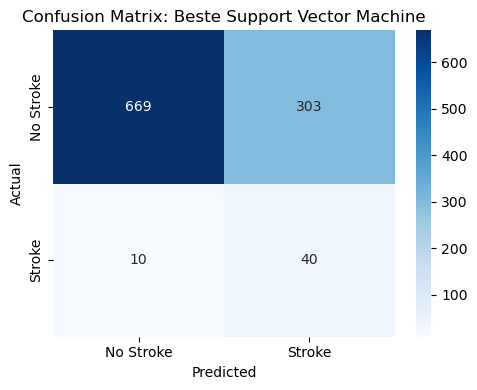

{'Model': 'Beste Support Vector Machine',
 'Train Accuracy': 0.704183998042574,
 'Train Precision': 0.12812960235640647,
 'Train Recall': 0.8743718592964824,
 'Train F1': 0.22350674373795762,
 'Train ROC-AUC': None,
 'Test Accuracy': 0.6937377690802349,
 'Test Precision': 0.11661807580174927,
 'Test Recall': 0.8,
 'Test F1': 0.2035623409669211,
 'Test ROC-AUC': None}

In [39]:
support_vector_classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(
    kernel='rbf',
    C=0.1,
    class_weight='balanced',
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=42
    ))
])
support_vector_classifier.fit(X_train, y_train)
# Verwendung der Evaluierungsfunktion
evaluate_model(support_vector_classifier, X_train, y_train, X_test, y_test, model_name='Beste Support Vector Machine')


In [40]:
# Limitations
# # Sind Fehlende Werte bei BMI missing (completely) at random (MCAR)?
# MCAR-Analyse
df_kopie['bmi_missing'] = df_kopie['bmi'].isnull()

features = df_kopie.drop(columns=['bmi', 'bmi_missing', 'stroke'])  # X ohne Ziel
features = pd.get_dummies(features, drop_first=True)

model = LogisticRegression(max_iter=1000)
model.fit(features, df_kopie['bmi_missing'])

print("Modell-Score:", model.score(features, df_kopie['bmi_missing']))
# Annahme: features ist ein DataFrame mit passenden Spaltennamen
coeff_df = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

coeff_df['Odds Ratio'] = coeff_df['Coefficient'].apply(lambda x: round(np.exp(x), 2))
print(coeff_df)

Modell-Score: 0.9606576629477392
                           Feature  Coefficient  Odds Ratio
12     smoking_status_never smoked    -0.956371        0.38
1                     hypertension     0.754269        2.13
2                    heart_disease     0.643468        1.90
4                      gender_Male     0.293783        1.34
6           work_type_Never_worked    -0.275200        0.76
5                 ever_married_Yes    -0.222723        0.80
13           smoking_status_smokes     0.203440        1.23
11  smoking_status_formerly smoked    -0.186956        0.83
9               work_type_children    -0.166230        0.85
8          work_type_Self-employed     0.068834        1.07
10            Residence_type_Urban     0.045727        1.05
0                              age     0.012175        1.01
7                work_type_Private    -0.008230        0.99
3                avg_glucose_level     0.005156        1.01


In [41]:
# Interaktionseffekte
df_scaled = df_kopie.copy()

scaler = StandardScaler()
df_scaled['age_scaled'] = scaler.fit_transform(df_kopie[['age']])

model = smf.logit("stroke ~ age_scaled + heart_disease + age_scaled:heart_disease", data=df_scaled).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.157327
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 5109
Model:                          Logit   Df Residuals:                     5105
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.1923
Time:                        12:13:45   Log-Likelihood:                -803.78
converged:                       True   LL-Null:                       -995.14
Covariance Type:            nonrobust   LLR p-value:                 1.234e-82
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.0729      0.141    -28.889      0.000      -4.349